In [1]:
import pickle as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from tqdm import tqdm

In [2]:
df = p.load(open('total.p','rb'))

In [3]:
all_subjects = np.concatenate((np.arange(11,25),np.arange(26,45)))

In [38]:
# Book-keeping Functions

def num_to_epoch(epoch_number):
    if epoch_number == 0:
        return 'UP1'
    elif epoch_number == 1:
        return 'UP2'
    elif epoch_number == 2:
        return 'P1'
    elif epoch_number == 3:
        return 'P2'
    elif epoch_number == 4:
        return 'REC'
    else:
        raise Exception('Invalid Epoch Number')

def num_to_subject(subject_number):
    return 'Subject'+str(subject_number)

def get_signal(measure, epoch, subjno):
    if isinstance(epoch,str):
        return df.loc[measure, epoch][num_to_subject(subjno)][:,0]
    elif isinstance(epoch, int):
        return df.loc[measure, num_to_epoch(epoch)][num_to_subject(subjno)][:,0]
    
def full_signal(measure, subjno):
    return np.concatenate((
        df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)][:,0],
        df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)][:,0],
    ))

def is_perturbed(epoch):
    if epoch == 0 or epoch == 1 or epoch == 4:
        return 0
    elif epoch == 2 or epoch == 3:
        return 1
    
def scaled_correlation_time(signal1, signal2):
    acorr = np.correlate(signal1, signal2, mode='full')
    acorr = acorr[(acorr.size // 2 ):] / np.max(acorr)
#     plt.plot(acorr)
    tau = np.argmax([acorr < 1/np.exp(1)])
    return tau / len(signal1)

def plot_full_experiment(measure, subjno):
    s1 = df.loc[measure, num_to_epoch(0)][num_to_subject(subjno)][:,0]
    s2 = df.loc[measure, num_to_epoch(1)][num_to_subject(subjno)][:,0]
    s3 = df.loc[measure, num_to_epoch(2)][num_to_subject(subjno)][:,0]
    s4 = df.loc[measure, num_to_epoch(3)][num_to_subject(subjno)][:,0]
    s5 = df.loc[measure, num_to_epoch(4)][num_to_subject(subjno)][:,0]
    fullsignal = np.concatenate((s1,s2,s3,s4,s5))
    plt.plot(fullsignal,'k',label = measure)
    plt.axvline(x = len(s1), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3), color = 'k', linestyle = '--')
    plt.axvline(x = len(s1)+len(s2)+len(s3)+len(s4), color = 'k', linestyle = '--')
    plt.legend()

In [349]:
# Signal Statistics

def signal_statistics(signal):
    mean = np.mean(signal)
    std = np.std(signal)
    skewness = stats.skew(signal)
    kurtosis = stats.kurtosis(signal)
    maximum = np.max(signal)
    minimum = np.min(signal)
    iqr = stats.iqr(signal)
    variation = stats.variation(signal)
    entropy = stats.entropy(np.abs(signal))
    corrtime = scaled_correlation_time(signal,signal)
    
    return np.asarray([mean, std, skewness, kurtosis, maximum, minimum, iqr, variation, entropy, corrtime])

### Some Visualization

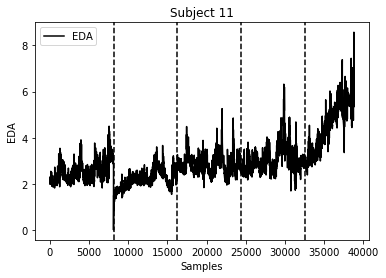

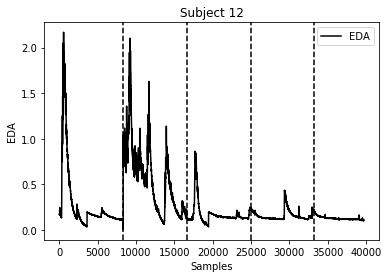

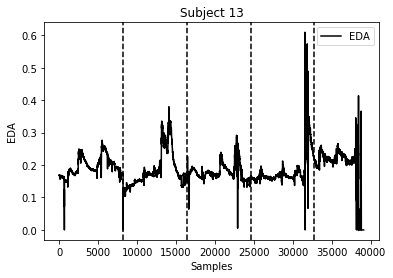

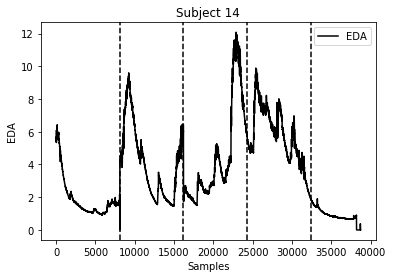

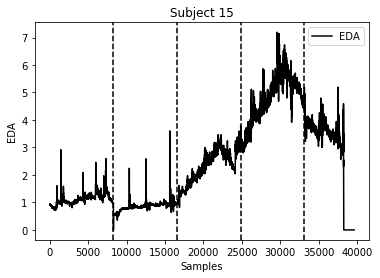

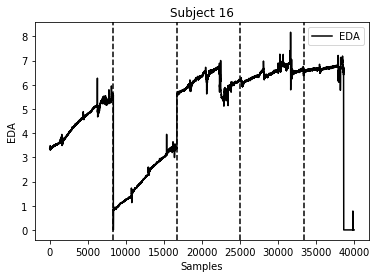

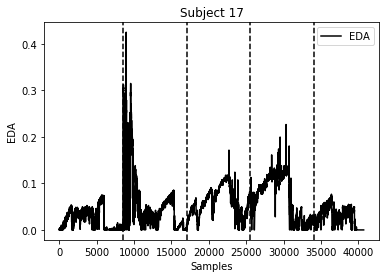

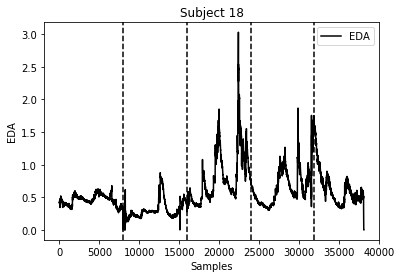

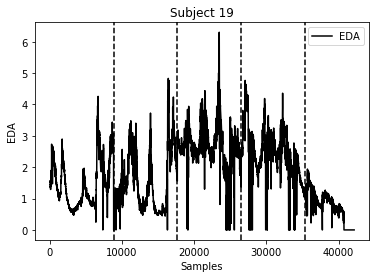

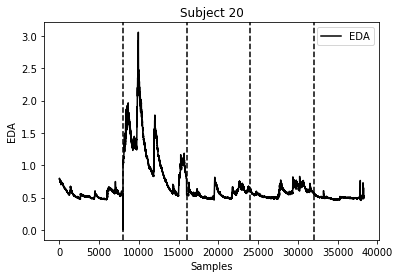

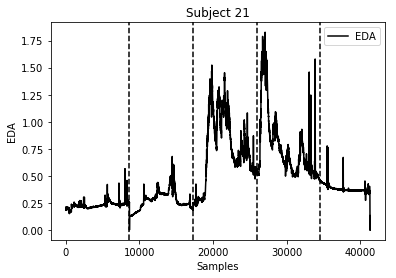

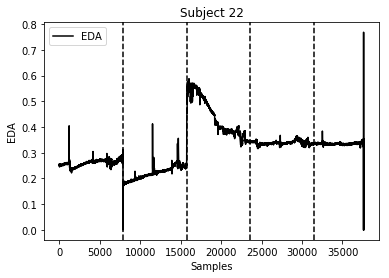

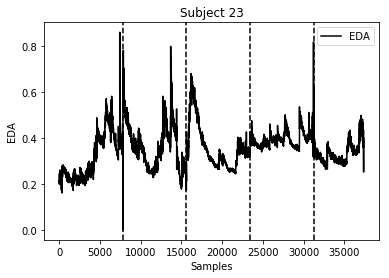

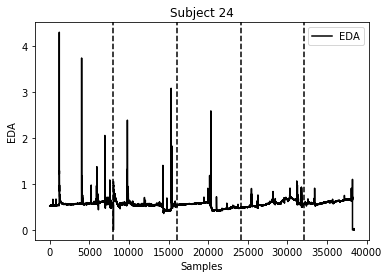

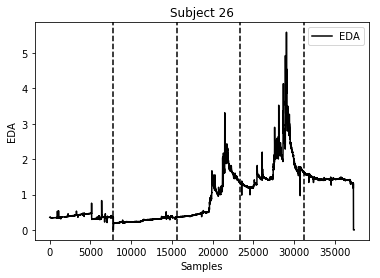

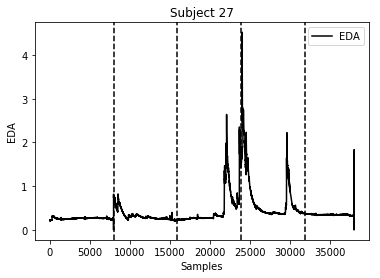

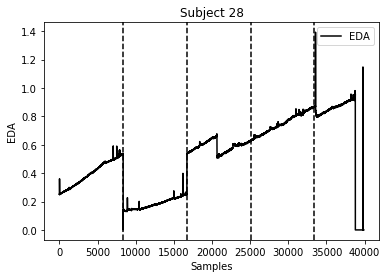

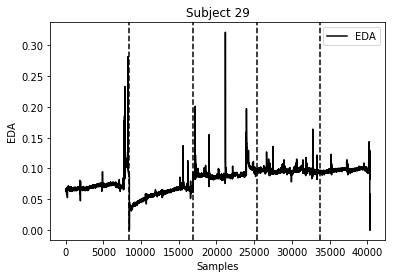

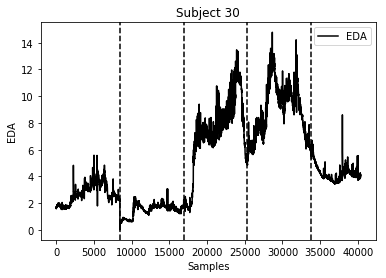

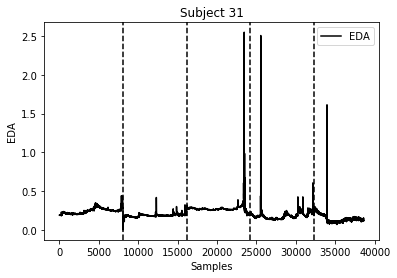

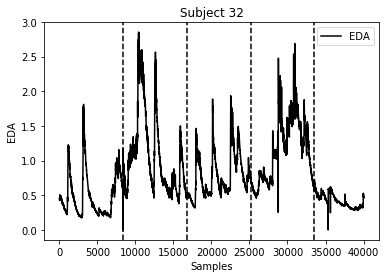

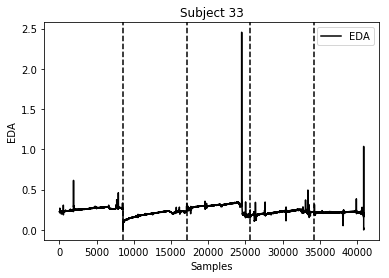

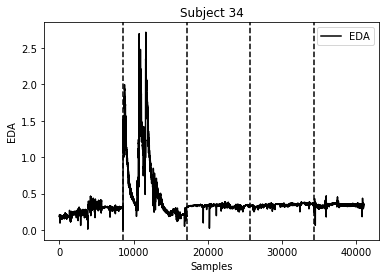

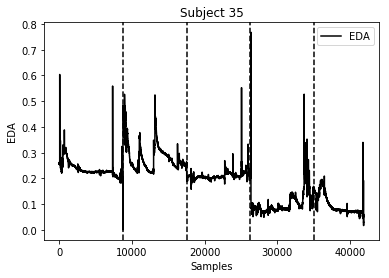

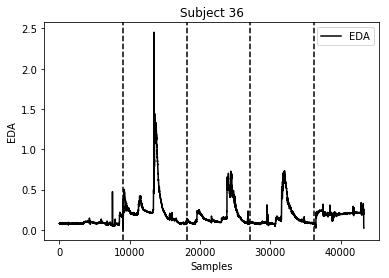

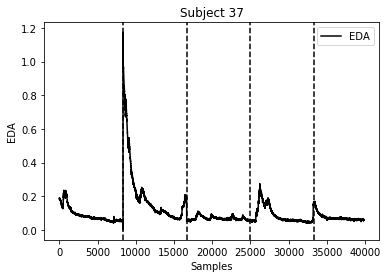

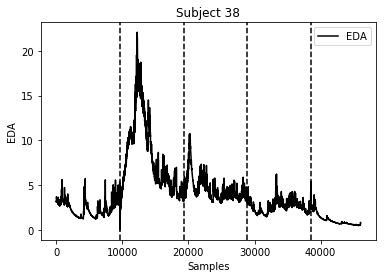

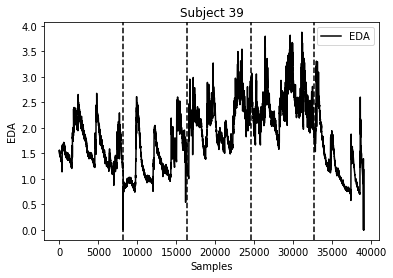

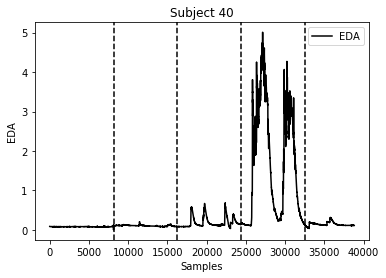

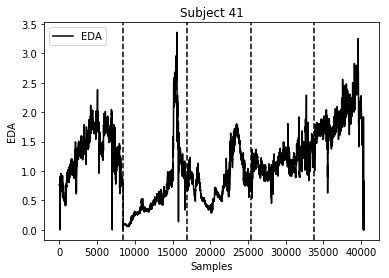

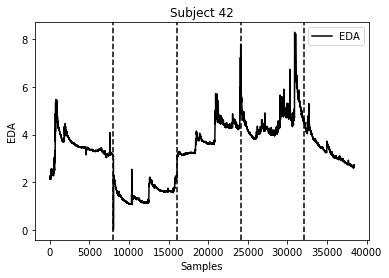

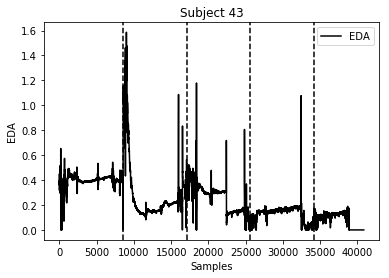

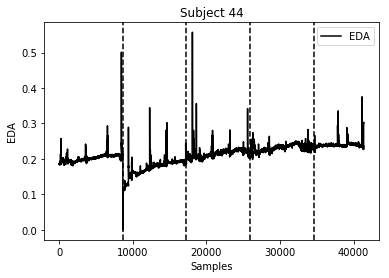

In [350]:
for i in all_subjects:
    plt.figure()
    plot_full_experiment('EDA',i)
    plt.title('Subject %i'%i)
    plt.xlabel('Samples')
    plt.ylabel('EDA')
    plt.show()

In [351]:
s = np.concatenate((get_signal('EDA',1,12), get_signal('EDA',2,12)))

In [352]:
hrfeatures = [];
tempfeatures = [];
edafeatures = [];

allfeatures = [];

targets = [];

for subjno in tqdm(all_subjects):
    
    subject_baseline_eda = np.concatenate((get_signal('EDA',0,subjno), get_signal('EDA',1,subjno)))
    subject_perturbed_eda = np.concatenate((get_signal('EDA',2,subjno), get_signal('EDA',3,subjno)))
    lower_quantile = np.quantile(subject_baseline_eda,.5)
    interquart = stats.iqr(subject_baseline_eda)
    basepeak = np.max(subject_baseline_eda)
    perturbedpeak = np.max(subject_perturbed_eda)
    peakratio = np.asarray([perturbedpeak/basepeak])
    
    for epoch in range(4):
        hr_signal = get_signal('HR',epoch,subjno)
        hrfeature = signal_statistics(hr_signal)
        hrfeatures.append(hrfeature)
        
        temp_signal = get_signal('TEMP',epoch,subjno)
        tempfeature = signal_statistics(temp_signal)
        tempfeatures.append(tempfeature)
        
        eda_signal = get_signal('EDA',epoch,subjno)
        normalized_eda_signal = (eda_signal - lower_quantile) / interquart
        edafeature = signal_statistics(eda_signal)
        edafeatures.append(edafeature)
        
        ## add cross-features
        
        xcorr_hr_temp = scaled_correlation_time(hr_signal,temp_signal)
        xcorr_hr_eda = scaled_correlation_time(hr_signal,eda_signal)
        xcorr_temp_eda = scaled_correlation_time(temp_signal,eda_signal)
        
        xcorr_feature = np.asarray([xcorr_hr_temp,xcorr_hr_eda,xcorr_temp_eda])
        
        pert = is_perturbed(epoch)
        targets.append(is_perturbed(epoch))
        
        allfeature = np.concatenate((hrfeature, tempfeature, edafeature, xcorr_feature, peakratio))
        allfeatures.append(allfeature)
        
        allfeature_names = ['hr_mean', 'hr_std', 'hr_skewness', 'hr_kurtosis', 'hr_maximum', 'hr_minimum', \
                            'hr_iqr', 'hr_variation', 'hr_entropy', 'hr_corrtime',\
                            'temp_mean', 'temp_std', 'temp_skewness', 'temp_kurtosis', \
                            'temp_maximum', 'temp_minimum', 'temp_iqr', 'temp_variation', 'temp_entropy','temp_corrtime',\
                            'eda_mean', 'eda_std', 'eda_skewness', 'eda_kurtosis', \
                            'eda_maximum', 'eda_minimum', 'eda_iqr', 'eda_variation', 'eda_entropy', 'eda_corrtime',\
                           'xcorr_hr_temp','xcorr_hr_eda','xcorr_temp_eda','peakratio']




  0%|          | 0/33 [00:00<?, ?it/s]


  3%|▎         | 1/33 [00:00<00:06,  4.60it/s]


  6%|▌         | 2/33 [00:00<00:06,  4.74it/s]


  9%|▉         | 3/33 [00:00<00:06,  4.86it/s]


 12%|█▏        | 4/33 [00:00<00:05,  4.96it/s]


 15%|█▌        | 5/33 [00:00<00:05,  5.03it/s]


 18%|█▊        | 6/33 [00:01<00:05,  4.85it/s]


 21%|██        | 7/33 [00:01<00:05,  4.97it/s]


 24%|██▍       | 8/33 [00:01<00:04,  5.08it/s]


 27%|██▋       | 9/33 [00:01<00:04,  4.96it/s]


 30%|███       | 10/33 [00:01<00:04,  5.09it/s]


 33%|███▎      | 11/33 [00:02<00:04,  5.04it/s]


 36%|███▋      | 12/33 [00:02<00:04,  5.14it/s]


 39%|███▉      | 13/33 [00:02<00:03,  5.32it/s]


 42%|████▏     | 14/33 [00:02<00:03,  5.34it/s]


 45%|████▌     | 15/33 [00:02<00:03,  5.45it/s]


 48%|████▊     | 16/33 [00:03<00:03,  5.39it/s]


 52%|█████▏    | 17/33 [00:03<00:03,  5.28it/s]


 55%|█████▍    | 18/33 [00:03<00:02,  5.21it/s]


 58%|█████▊    | 19/33 [00:03<00:02,  5.09it/s]


 61%|██████    

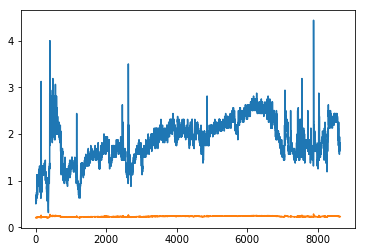

In [353]:
plt.plot(normalized_eda_signal)
plt.plot(eda_signal)

In [354]:
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut

In [355]:
X = np.asarray(allfeatures)
t = np.asarray(targets)
encoder = preprocessing.OneHotEncoder(categories = 'auto')
t_onehot = encoder.fit_transform(t.reshape(-1,1)).toarray()

sc = preprocessing.MinMaxScaler()
X_scaled = sc.fit_transform(X)

In [303]:
clf = LogisticRegression(solver = 'lbfgs', max_iter = 1000000)

In [304]:
clf.fit(X,t)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [305]:
clf.score(X,t)

0.7196969696969697

## Support Vector Machine

In [306]:
X = np.asarray(allfeatures)
t = np.asarray(targets)

sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(X)

In [321]:
loo = LeaveOneOut()
preds = [];
for train_idx,test_idx in tqdm(loo.split(X)):
    X_train,y_train = X_scaled[train_idx],t[train_idx]
    X_test,y_test = X_scaled[test_idx],t[test_idx]
    svc = SVC(gamma = .01, C = 1000, tol = 0.01, kernel = 'rbf')
    svc.fit(X_train,y_train)
    preds.append(svc.predict(X_test)[0])



0it [00:00, ?it/s]

48it [00:00, 479.53it/s]

96it [00:00, 477.35it/s]

132it [00:00, 480.13it/s]

In [322]:
np.mean(preds == t)

0.6590909090909091

## Random Forest

In [331]:
X = np.asarray(allfeatures)
t = np.asarray(targets)

In [332]:
loo = LeaveOneOut()
preds = [];
for train_idx,test_idx in tqdm(loo.split(X)):
    X_train,y_train = X[train_idx],t[train_idx]
    X_test,y_test = X[test_idx],t[test_idx]
    rf = RandomForestClassifier(n_estimators = 100)
    rf.fit(X_train,y_train)
    preds.append(rf.predict(X_test)[0])




0it [00:00, ?it/s]


2it [00:00, 13.29it/s]


4it [00:00, 13.37it/s]


6it [00:00, 13.62it/s]


8it [00:00, 13.74it/s]


10it [00:00, 13.89it/s]


12it [00:00, 13.82it/s]


14it [00:01, 13.89it/s]


16it [00:01, 13.90it/s]


18it [00:01, 13.82it/s]


20it [00:01, 13.47it/s]


22it [00:01, 13.45it/s]


24it [00:01, 13.28it/s]


26it [00:01, 13.13it/s]


28it [00:02, 13.43it/s]


30it [00:02, 13.74it/s]


32it [00:02, 13.50it/s]


34it [00:02, 13.50it/s]


36it [00:02, 13.55it/s]


38it [00:02, 13.28it/s]


40it [00:02, 13.22it/s]


42it [00:03, 13.20it/s]


44it [00:03, 12.92it/s]


46it [00:03, 12.84it/s]


48it [00:03, 12.81it/s]


50it [00:03, 12.88it/s]


52it [00:03, 12.75it/s]


54it [00:04, 12.48it/s]


56it [00:04, 12.49it/s]


58it [00:04, 12.60it/s]


60it [00:04, 12.58it/s]


62it [00:04, 12.52it/s]


64it [00:04, 12.45it/s]


66it [00:05, 12.29it/s]


68it [00:05, 12.27it/s]


70it [00:05, 12.62it/s]


72it [00:05, 12.74it/s]


74it [00:05, 12.79it/s]


76it [00:05, 13.17

In [333]:
accuracy = np.mean((preds - t) == 0)
print('LOO Accuracy: %.2f'%accuracy)

LOO Accuracy: 0.70


In [334]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = allfeature_names,
                                    columns=['importance']).sort_values('importance', ascending=False)

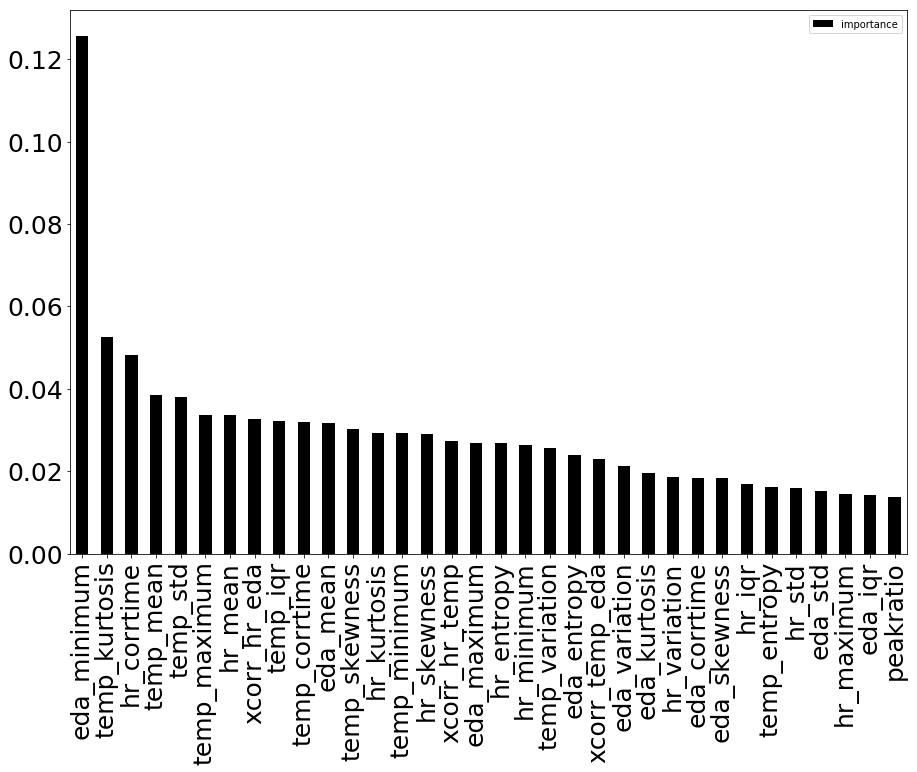

In [335]:
feature_importances.plot(kind = 'bar', figsize = (15,10), color = 'k', fontsize = 25)